# Tutorial: Gene Regulatory Networks
In this tutorial, we'll use BRICK to interpret a Gene Regulatory Network (GRN) result.

## Import packages

In [1]:
import pandas as pd
import re

import BRICK

## Configure your LLM and Knowledge Graph

In [ ]:
from dotenv import dotenv_values
import json
config = dotenv_values('/workspace/data/brick.env')
kg_url = config.get('KG_URL')
kg_auth = (config.get('KG_AUTH_USER'), config.get('KG_AUTH_PASS'))
model = config.get("MODEL_TYPE")
url = config.get("LLM_URL")
api_key = config.get("API_KEY")
llm_params = json.loads(config.get("LLM_PARAMS"))

BRICK.config(url=kg_url, auth=kg_auth)
BRICK.config_llm(modeltype=model, base_url=url,api_key=api_key, llm_params=llm_params)

Graph database has been configured and initialized successfully.
LLM has been configured and initialized successfully.


# Get verified TF-regulon
We'll use pyScenic to get TF-regulon. 

An example code of pyScenic to get all necessary files: 
1) calculate GRN
``` bash
pyscenic grn --seed 7 ./expression_matrix.csv ./${tfs_allTFs_mm.txt} -o adj_0619.tsv --num_workers 4
```

2) filter module
``` bash
pyscenic ctx adj_0619.tsv mm10_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather --annotations_fname motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl --expression_mtx_fname expression_matrix_converted.csv --output regulon_0619_modules.tsv --mode "dask_multiprocessing" --num_workers 4
```

3) calculate AUCell score
``` bash
pyscenic aucell expression_matrix_converted.csv regulon_0619_modules.tsv  --output regulon_0619_AUC_modules.csv --num_workers 4
```
\
After running pyScenic, we can use modules.tsv (regulon_0619_modules) file and get_verified_tf() function to get verified tf-regulon

In [3]:
def extract_genes(target_genes_str):
    """ 
    Extracts gene names from a string and returns a unique set of genes.

    This function parses a string containing a list of gene names and extracts them. 
    It is typically used to retrieve gene information from text-based query results.

    Args:
        target_genes_str (str): A string containing gene names, typically formatted as `("GeneA", "GeneB", "GeneC")`.

    Returns:
        set: A set of unique gene names extracted from the input string.
    """
    matches = re.findall(r"\('([^']+)'", target_genes_str)
    return set(matches)

def get_verified_tf(module_file):
    """ 
    Parses a transcription factor (TF) regulation file and filters TFs.

    This function extracts TFs and their target genes from a provided regulation module file (CSV/TSV format) 
    and identifies TFs whose target genes intersect with the input gene list.

    Args:
        module_file (str): Path to the file containing transcription factor (TF) information (CSV or TSV format).
        gene_list (list): A list of target genes to find overlapping TF-associated genes.

    Returns:
        pd.DataFrame: A DataFrame containing TFs and their target genes that overlap with the input gene list, 
                      sorted in descending order of overlap size.
    """
    file_extension = module_file.split('.')[-1].lower()
    if file_extension == 'tsv':
        module_df = pd.read_csv(f"{module_file}", sep="\t")
    elif file_extension == 'csv':
        module_df = pd.read_csv(f"{module_file}")
    
    module_df = module_df.rename(columns={"Unnamed: 0": "TF", "Enrichment.6": "TargetGenes"})
    module_df = module_df[["TF", "TargetGenes"]].dropna()

    module_df["RegulonGenes"] = module_df["TargetGenes"].apply(extract_genes)
    #print(module_df.head())

    intersection_dict = {}


    for _, row in module_df.iterrows():
        tf = row["TF"]
        regulon_genes = row["RegulonGenes"]
        intersection_dict[tf] = {
            "OverlappingGenes": regulon_genes,
            "IntersectionSize": len(regulon_genes),
            "Regulon":regulon_genes
        }

    intersection_df = pd.DataFrame.from_dict(intersection_dict, orient="index")
    intersection_df = intersection_df.sort_values(by="IntersectionSize", ascending=False)
    return intersection_df

In [4]:
module_file = "./data/regulon_0619_modules.tsv"
top_tf = get_verified_tf(module_file)

In [5]:
top_tf.head(2)

,OverlappingGenes,IntersectionSize,Regulon
Stat2,"{Gm12185, Ms4a4c, Slfn5, Frmd4b, Ifi27l2a, Klra2, E230029C05Rik, Plcl1, Card11, Btla, Eps8, H2-Aa, Oasl1, Cadm1, Rasgrp1, P2ry12, Irgm1, Shtn1, Ahr, Pik3r5, Oas3, Ccr2, Cx3cr1, Rbpj, Gbp9, Ccnd3, Apba1, Ciita, Irf7, Xaf1, Agmo, Gbp8, Capn2, Adgb, Aph1c, Ifi214, Rab7b, Prkcg, Zfp366, Ms4a6d, Ctnnd2, Rasgrp3, Cd74, Abcg3, Rubcnl, Arhgap22, Mrc1, Tbc1d4, Slc9a9, Pde7b, Lifr, Siglec1, Slfn8, Gm12159, Mndal, Gbp4, Tnfrsf11a, Kmo, Ophn1, Gpr141, Dusp16, Cd36, Ahnak}",63,"{Gm12185, Ms4a4c, Slfn5, Frmd4b, Ifi27l2a, Klra2, E230029C05Rik, Plcl1, Card11, Btla, Eps8, H2-Aa, Oasl1, Cadm1, Rasgrp1, P2ry12, Irgm1, Shtn1, Ahr, Pik3r5, Oas3, Ccr2, Cx3cr1, Rbpj, Gbp9, Ccnd3, Apba1, Ciita, Irf7, Xaf1, Agmo, Gbp8, Capn2, Adgb, Aph1c, Ifi214, Rab7b, Prkcg, Zfp366, Ms4a6d, Ctnnd2, Rasgrp3, Cd74, Abcg3, Rubcnl, Arhgap22, Mrc1, Tbc1d4, Slc9a9, Pde7b, Lifr, Siglec1, Slfn8, Gm12159, Mndal, Gbp4, Tnfrsf11a, Kmo, Ophn1, Gpr141, Dusp16, Cd36, Ahnak}"
Irf7,"{Gm12185, Parp12, Plbd1, Ednrb, Gch1, Ifi27l2a, Phf11d, Dhx58, Hivep2, Epsti1, Ifi213, Oasl1, Clec9a, Ifi208, Eps8, Rasgrp1, Dab2, Irgm1, Hsh2d, Gpnmb, Oas3, Pde1b, F11r, Oasl2, Plpp1, Ifih1, Ifit1, Vcan, Slco2b1, Irf7, Mx2, Ifitm3, Ciita, Xaf1, Krt79, Pltp, Usp18, Abca1, Ddx60, Cmpk2, Zbp1, Oas1c, Ifit3b, Xdh, Mx1, Trim30d, Pde7b, Slamf7, Oas2, Slfn8, Trim5, Kmo, Rsad2, Helz2, Rtp4, Ifit1bl1, Ctnnd2, H2-T24, Samd9l}",59,"{Gm12185, Parp12, Plbd1, Ednrb, Gch1, Ifi27l2a, Phf11d, Dhx58, Hivep2, Epsti1, Ifi213, Oasl1, Clec9a, Ifi208, Eps8, Rasgrp1, Dab2, Irgm1, Hsh2d, Gpnmb, Oas3, Pde1b, F11r, Oasl2, Plpp1, Ifih1, Ifit1, Vcan, Slco2b1, Irf7, Mx2, Ifitm3, Ciita, Xaf1, Krt79, Pltp, Usp18, Abca1, Ddx60, Cmpk2, Zbp1, Oas1c, Ifit3b, Xdh, Mx1, Trim30d, Pde7b, Slamf7, Oas2, Slfn8, Trim5, Kmo, Rsad2, Helz2, Rtp4, Ifit1bl1, Ctnnd2, H2-T24, Samd9l}"


# visualize the verified GRN 

In [6]:
cypher_grn = ("MATCH (n:Gene)-[r:regulated|activate|interact_with]->(m:Gene|Protein) WHERE n.name IN $TF AND m.name IN $gene_list RETURN n,r,m")

tf_interest = "Fos"
TF = re.findall(r"^[^(]+", tf_interest)

target_genes = list(top_tf.loc[TF, 'Regulon'])[0]

params = {"TF": TF, "gene_list": list(target_genes)}

In [7]:
result = BRICK.qr.query_cypher(cypher_grn,parameters=params)

verified_gene = result["m.name"].tolist() 

Graph saved to ./fos_kg.svg


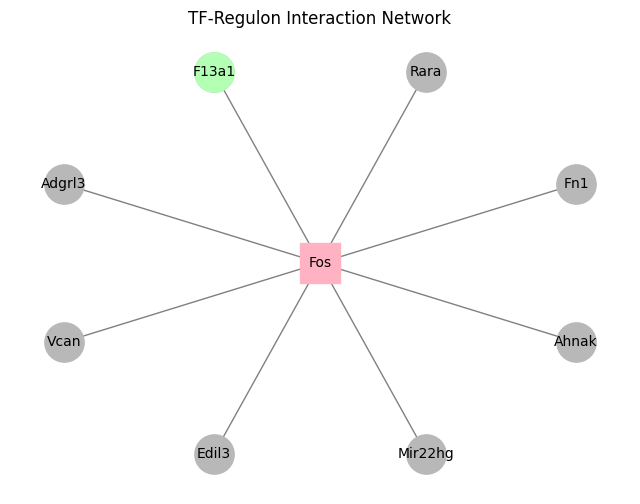

In [8]:
BRICK.pl.visualize_tf_regulon(TF,top_tf,verified_gene,save_path="./fos_kg.svg")

# Generate Interpretation

You can use your configured LLM to generate interpretations for your data. We have provided a default question and prompt for each sub-task, but feel free to customize or create your own as needed.
### Interpret Gene Regulatory Networks
Use a customized Cypher query to retrieve information from the Knowledge Graph.

For example, retrieve details about the transcription factor (TF) "Pparg" and its associated regulon.

In [9]:
regulon = top_tf.loc[TF,"Regulon"].explode().tolist()
tf_list = list(set(result["n.name"]))

result = BRICK.inp.analyse_grn(tf_list,verified_gene,regulon,sub_task="analyse how this TF-regulon regulate the develop path from conventional dendritic cell to adipose macrophage")
print("Generated Answer:", result)

Now generating answer ... 

Generated Answer: ### Analysis of the TF-Regulon and Its Role in the Developmental Path from Conventional Dendritic Cells to Adipose Macrophages

#### Transcription Factor: Fos
**Fos** is a member of the AP-1 (Activator Protein 1) family of transcription factors. It forms heterodimers with Jun proteins to regulate gene expression. Fos is known to play a crucial role in cell proliferation, differentiation, and response to various stimuli, including stress and growth factors. In the context of immune cells, Fos has been implicated in the regulation of inflammatory responses and the development of immune cell lineages.

#### Verified Gene: F13a1
**F13a1** (Coagulation Factor XIII A Chain) is a gene that encodes a subunit of coagulation factor XIII, which is involved in the final steps of blood coagulation and wound healing. The fact that F13a1 is both calculated by SCENIC and experimentally verified as a target of Fos suggests a strong regulatory relationship. 